In [30]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
data_dict = loadmat('../data/Brandon_Stitched_data.mat')

In [3]:
import pandas as pd

df = pd.DataFrame();

df['traces_raw'] = data_dict['traces_raw'][0]
df['mouse_id']   = data_dict['mouse_ID']
df['session_id'] = data_dict['session_ID']
df['condition']  = data_dict['LvsR']

In [53]:
def condition_average(trials, conditions):
    return np.hstack([trials[conditions==c].mean(axis=0) for c in conditions.unique()])

def concatenate_session_averages(trials, sessions, conditions=None):
    if conditions is not None:
        return np.concatenate([condition_average(trials[sessions==s], conditions=conditions[sessions==s]) for s in sessions.unique()])
    else:
        return np.concatenate([trials[s].mean(axis=0) for s in sessions.unique()])
    
def condition_PCA(X, n_components, n_conditions):
    results = PCA().fit(StandardScaler().fit(X).transform(X))
    return np.hsplit(results.components_[:n_components], n_conditions)

def get_projection_weights(X, Z):
        
    alphas = np.linspace(-2, 1, 30)
    model = RidgeCV(alphas=alphas, fit_intercept=True).fit(X.T, Z.T)
    W = model.coef_
    b = model.intercept_
    return W, b

def project_data(trials, sessions, n_components, conditions=None):
    X = concatenate_session_averages(trials=trials, sessions=sessions, conditions=conditions)
    Z = condition_PCA(X=X, n_components=n_components, n_conditions=len(conditions.unique()))
    trials_projected = [[]]*len(trials)
    data_dict = {}
    for c, Zc in zip(conditions.unique(), Z):
        for s in sessions.unique():
            trials_sc, idxs_sc = np.array(trials[(sessions==s) & (conditions==c)].tolist()), np.arange(len(trials))[(sessions==s) & (conditions==c)]
            mean_sc = trials_sc.mean(axis=0)
            W_sc_in, b_sc_in = get_projection_weights(mean_sc, Zc)
            W_sc_out, b_sc_out = get_projection_weights(Zc, mean_sc)
            trials_projected_sc = trials_sc.transpose(0, 2, 1) @ W_sc_in.T + b_sc_in
            for trial, idx in zip(trials_projected_sc, idxs_sc):
                trials_projected[idx] = trial.T
            
            data = np.copy(trials_sc)
            np.random.shuffle(data)
            train_len = min(len(data) - 1, int(len(data) * 0.8))
            
            data_dict['s%i_c%i'%(s, c)] = {'train_data' : data[:train_len].transpose(0, 2, 1),
                                           'valid_data' : data[train_len:].transpose(0, 2, 1),
                                           'W_in' : W_sc_in.T, 'b_in' : b_sc_in, 'W_out' : W_sc_out.T, 'b_out' : b_sc_out}
    return trials_projected, data_dict
        
def projection_to_df(df, mouse_id, n_components):
    df_m = df[df['mouse_id']==mouse_id]
    trials = df_m['traces_raw'];
    sessions = df_m['session_id'];
    conditions = df_m['condition'];
    trials_projected, data_dict= project_data(trials=trials, sessions=sessions, conditions=conditions, n_components=n_components)
    df_m['traces_projected'] = trials_projected
    return df_m, data_dict
        
def project_and_concatenate_mice(df, mice, n_components):
    if type(n_components) is int:
        n_components = [n_components] * len(mice)
    if len(n_components) == 1:
        n_components = [n_components[0]] * len(mice)
        
    assert len(n_components) == len(mice), 'n_components must have same length as mice'
    return pd.concat([projection_to_df(df=df, mouse_id=m, n_components=n) for m, n in zip(mice, n_components)])

In [54]:
df_2, data_dict = projection_to_df(df, mouse_id=2, n_components=40)
data_dict['dt'] = 1./30

/home/luke/anaconda2/envs/pytorch11/lib/python3.5/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [62]:
len(np.arange(10)[:9])

9

In [59]:
for key in data_dict.keys():
    if type(data_dict[key]) is dict:
        print(data_dict[key]['valid_data'].shape)

(4, 180, 414)
(4, 180, 451)
(4, 180, 442)
(2, 180, 468)
(6, 180, 503)
(2, 180, 420)
(5, 180, 514)
(5, 180, 454)
(4, 180, 442)
(6, 180, 503)
(7, 180, 493)
(3, 180, 451)
(2, 180, 468)
(6, 180, 426)
(5, 180, 508)
(4, 180, 503)
(6, 180, 462)
(3, 180, 577)
(6, 180, 454)
(2, 180, 420)
(5, 180, 426)
(3, 180, 577)
(5, 180, 508)
(5, 180, 441)
(5, 180, 493)
(6, 180, 514)
(6, 180, 503)
(6, 180, 462)
(6, 180, 441)
(4, 180, 414)


In [63]:
pickle.dump(data_dict, open('./data/mouse_2_brandon_condAvg.pkl', 'wb'))

In [40]:
from dataset import LFADS_MultiSession_Dataset

keys = [key for key in data_dict.keys() if type(key) is int]
keys.sort()
train_data_list  = [data_dict[key]['train_data'] for key in keys]
valid_data_list  = [data_dict[key]['valid_data'] for key in keys]

train_ds    = LFADS_MultiSession_Dataset(train_data_list, device='cpu')

In [42]:
train_ds.data_list

[]

In [521]:
df_proj = project_and_concatenate_mice(df=df, mice=[1, 2], n_components=40)

/home/luke/anaconda2/envs/pytorch11/lib/python3.5/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [522]:
trials = df_proj['traces_projected']
sessions = df_proj['session_id']
conditions = df_proj['condition']

X = concatenate_session_averages(trials=trials, sessions=sessions, conditions=conditions)
Z = condition_PCA(X=X, n_components=360, n_conditions=len(conditions.unique()))

In [523]:
results = PCA().fit(StandardScaler().fit(X).transform(X))

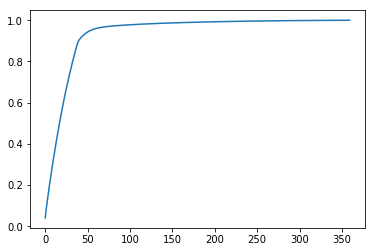

In [524]:
plt.plot(results.explained_variance_ratio_.cumsum())

In [525]:
results.explained_variance_ratio_.cumsum()[20]

0.5724328846857827

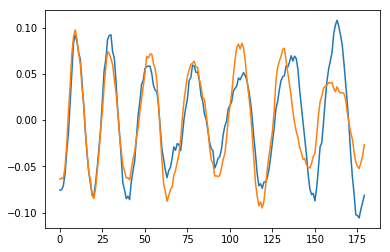

In [553]:
i = 30
plt.plot(Z[0][i])
plt.plot(Z[1][i])

In [329]:
mouse_2_sessions = df[df['mouse_id']==2]['session_id'].unique()
mouse_2_conditions = df[df['mouse_id']==2]['condition'].unique()

In [330]:
condition_session_mean_list = []
for condition in mouse_2_conditions:
    session_mean_list = []
    for session in mouse_2_sessions:
        session_data = df[(df['session_id']==session) & (df['condition']==condition)]['traces_raw']
        session_data = [s.tolist() for s in session_data.values]
        session_data = np.array(session_data);
        session_mean_list.append(session_data.mean(axis=0))
    condition_session_mean_list.append(session_mean_list)

In [331]:
X = np.hstack((np.concatenate(condition_session_mean_list[0]), np.concatenate(condition_session_mean_list[1]))); X.shape

(7076, 360)

In [284]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [285]:
results = PCA().fit(StandardScaler().fit(X).transform(X))

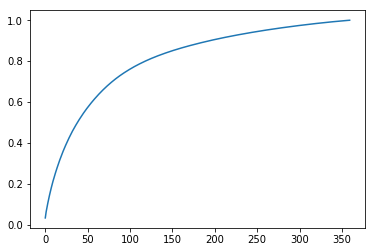

In [286]:
plt.plot(results.explained_variance_ratio_.cumsum())

In [287]:
list(zip(np.arange(results.n_components_), results.explained_variance_ratio_.cumsum()[:60]))

[(0, 0.03303490721958786),
 (1, 0.06268532791113934),
 (2, 0.08477399053361206),
 (3, 0.10595871569717093),
 (4, 0.1257610034432683),
 (5, 0.14462457558266592),
 (6, 0.16253032466138528),
 (7, 0.1793462200959398),
 (8, 0.19581526801371665),
 (9, 0.21117650091530474),
 (10, 0.22560716058312205),
 (11, 0.23951632912731696),
 (12, 0.25331891669000706),
 (13, 0.2667265275217373),
 (14, 0.27919024404158305),
 (15, 0.2916155844292293),
 (16, 0.30368780705224196),
 (17, 0.31550256880206745),
 (18, 0.3267075549084085),
 (19, 0.33769121420562753),
 (20, 0.34853202339306266),
 (21, 0.3589796182692758),
 (22, 0.36901447807210924),
 (23, 0.3788178885651477),
 (24, 0.38822045921572856),
 (25, 0.3975189591121833),
 (26, 0.40660172962967395),
 (27, 0.4155900192383074),
 (28, 0.42427921825214765),
 (29, 0.43282332302374743),
 (30, 0.4412273241909509),
 (31, 0.44928016759191586),
 (32, 0.45723525421881783),
 (33, 0.46478231632884576),
 (34, 0.4721974420305984),
 (35, 0.47954348092921323),
 (36, 0.48667

In [288]:
Y_mouse2 = results.components_[:60]
Y1, Y2 = np.hsplit(Y_mouse2[:60], 2)

# Z1 = results.components_[:60, :180]
# Z2 = results.components_[:60, 180:]

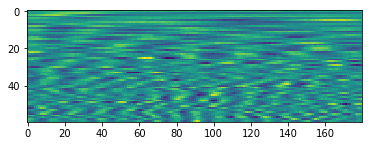

In [289]:
plt.imshow(Y1)

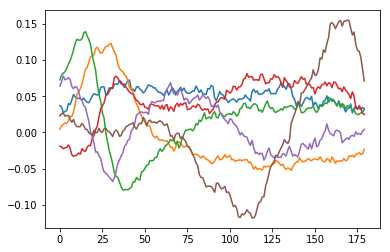

In [290]:
plt.plot(Y1[:6].T)

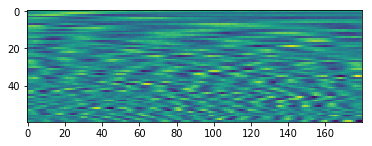

In [291]:
plt.imshow(Y2)

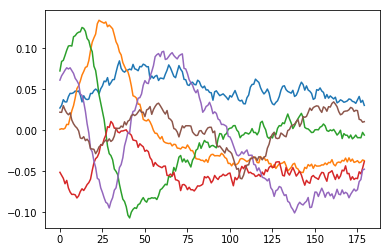

In [292]:
plt.plot(Y2[:6].T)

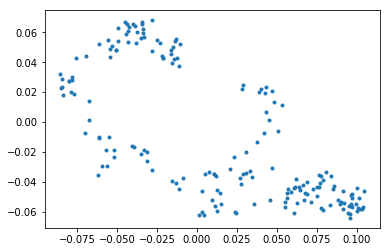

In [304]:
c = 6
plt.plot(Y1[c], Y2[c], '.')

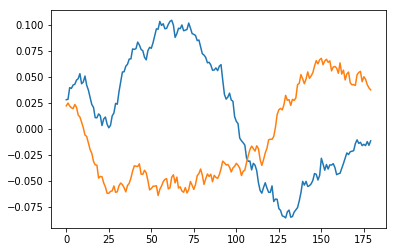

In [305]:
plt.plot(Y1[c])
plt.plot(Y2[c])

In [259]:
mouse_1_sessions = df[df['mouse_id']==1]['session_id'].unique()
mouse_1_conditions = df[df['mouse_id']==1]['condition'].unique()

In [260]:
condition_session_mean_list = []
for condition in mouse_1_conditions:
    session_mean_list = []
    for session in mouse_1_sessions:
        session_data = df[(df['session_id']==session) & (df['condition']==condition)]['traces_raw']
        session_data = [s.tolist() for s in session_data.values]
        session_data = np.array(session_data);
        session_mean_list.append(session_data.mean(axis=0))
    condition_session_mean_list.append(session_mean_list)

In [261]:
X = np.hstack((np.concatenate(condition_session_mean_list[0]), np.concatenate(condition_session_mean_list[1]))); X.shape

(2314, 360)

In [262]:
results = PCA().fit(StandardScaler().fit(X).transform(X))

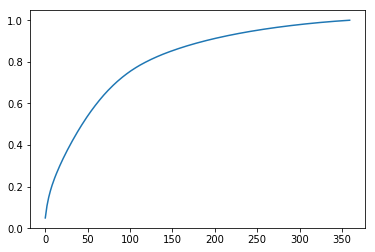

In [263]:
plt.plot(results.explained_variance_ratio_.cumsum())

In [264]:
list(zip(np.arange(results.n_components_), results.explained_variance_ratio_.cumsum()[:60]))

[(0, 0.04936872396868318),
 (1, 0.07891261618420023),
 (2, 0.10769607191399275),
 (3, 0.1280065273523163),
 (4, 0.14794448534655585),
 (5, 0.16438031932655617),
 (6, 0.17932199373394747),
 (7, 0.19308479705040113),
 (8, 0.2061654988602241),
 (9, 0.21808409375581628),
 (10, 0.22952895649517185),
 (11, 0.24064750032257487),
 (12, 0.25139710252406394),
 (13, 0.26132459903343586),
 (14, 0.27115200232727166),
 (15, 0.28069236353927735),
 (16, 0.2900986764154773),
 (17, 0.29936105008726305),
 (18, 0.30836102797788656),
 (19, 0.3171892021473075),
 (20, 0.3259169836886392),
 (21, 0.33451338538428005),
 (22, 0.3428112219075006),
 (23, 0.3510256645555764),
 (24, 0.3591528652742495),
 (25, 0.3672291728261083),
 (26, 0.37518558758960774),
 (27, 0.38293212180247144),
 (28, 0.3906609246322893),
 (29, 0.39831519937976156),
 (30, 0.4058115454724405),
 (31, 0.41328715813848055),
 (32, 0.42068785152977434),
 (33, 0.42793011527541847),
 (34, 0.43513735502689466),
 (35, 0.44226283826512336),
 (36, 0.44933

In [272]:
Y_mouse1 = results.components_[:60]
Y1, Y2 = np.hsplit(Y_mouse1, 2)

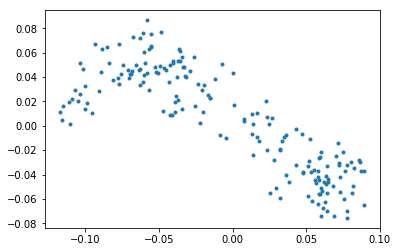

In [275]:
c = 6
plt.plot(Y1[c], Y2[c], '.')

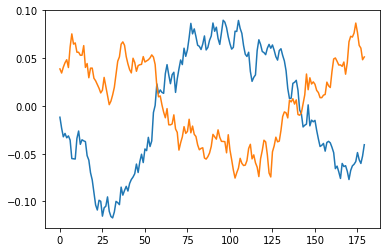

In [277]:
plt.plot(Y1[c])
plt.plot(Y2[c])

In [269]:
Y_mouse1.shape, 

(60, 360)

In [307]:
from sklearn.linear_model import Ridge, RidgeCV

In [319]:
alphas = np.logspace(-2, 1, base=10, num=10); alphas

array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ])

In [320]:
W_cond_in_list = []
b_cond_in_list = []

W_cond_out_list = []
b_cond_out_list = []

alphas = np.logspace(-2, 1, base=10, num=15); alphas
for session_mean_list, Z in zip(condition_session_mean_list, (Z1, Z2)):
    W_in_list = []
    b_in_list = []

    W_out_list = []
    b_out_list = []
    for X in session_mean_list:

        model = RidgeCV(alphas=alphas, fit_intercept=True).fit(X.T, Z.T)
        W_in_list.append(model.coef_)
        b_in_list.append(model.intercept_)
        print(model.alpha_)
        model = RidgeCV(alphas=alphas, fit_intercept=True).fit(Z.T, X.T)
        W_out_list.append(model.coef_)
        b_out_list.append(model.intercept_)
        print(model.alpha_)
        
    W_cond_in_list.append(W_in_list)
    b_cond_in_list.append(b_in_list)

    W_cond_out_list.append(W_out_list)
    b_cond_out_list.append(b_out_list)

0.01
0.07196856730011521
0.01
0.043939705607607904
0.01
0.043939705607607904
0.01
0.043939705607607904
0.01
0.07196856730011521
0.02682695795279726
0.07196856730011521
0.01
0.07196856730011521
0.01
0.07196856730011521
0.01
0.043939705607607904
0.01
0.07196856730011521
0.01
0.07196856730011521
0.01
0.043939705607607904
0.01
0.043939705607607904
0.01
0.043939705607607904
0.043939705607607904
0.11787686347935872
0.016378937069540637
0.07196856730011521
0.01
0.043939705607607904
0.01
0.07196856730011521
0.01
0.043939705607607904
0.01
0.043939705607607904
0.02682695795279726
0.07196856730011521
0.01
0.043939705607607904
0.01
0.043939705607607904
0.01
0.043939705607607904
0.01
0.07196856730011521
0.016378937069540637
0.07196856730011521
0.01
0.043939705607607904
0.01
0.043939705607607904
0.01
0.043939705607607904
0.02682695795279726
0.07196856730011521


In [321]:
[w.shape for W_in_list in W_cond_in_list for w in W_in_list], [w.shape for  W_out_list in W_cond_out_list for w in W_out_list]

([(60, 577),
  (60, 454),
  (60, 441),
  (60, 503),
  (60, 514),
  (60, 420),
  (60, 503),
  (60, 442),
  (60, 508),
  (60, 414),
  (60, 451),
  (60, 426),
  (60, 493),
  (60, 462),
  (60, 468),
  (60, 577),
  (60, 454),
  (60, 441),
  (60, 503),
  (60, 514),
  (60, 420),
  (60, 503),
  (60, 442),
  (60, 508),
  (60, 414),
  (60, 451),
  (60, 426),
  (60, 493),
  (60, 462),
  (60, 468)],
 [(577, 60),
  (454, 60),
  (441, 60),
  (503, 60),
  (514, 60),
  (420, 60),
  (503, 60),
  (442, 60),
  (508, 60),
  (414, 60),
  (451, 60),
  (426, 60),
  (493, 60),
  (462, 60),
  (468, 60),
  (577, 60),
  (454, 60),
  (441, 60),
  (503, 60),
  (514, 60),
  (420, 60),
  (503, 60),
  (442, 60),
  (508, 60),
  (414, 60),
  (451, 60),
  (426, 60),
  (493, 60),
  (462, 60),
  (468, 60)])

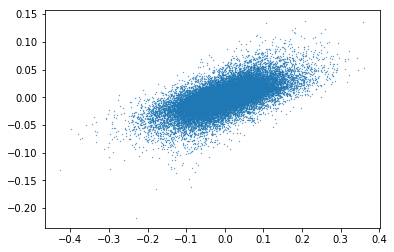

In [326]:
plt.scatter(W_in_list[3].ravel(), W_out_list[3].T.ravel(), s=0.1)

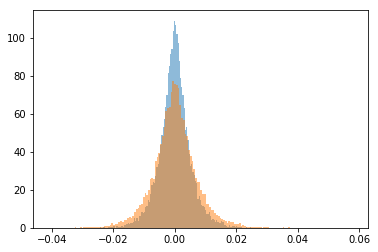

In [208]:
plt.hist(W_out_list[4].ravel(), bins='auto', density=True, histtype='stepfilled', alpha=0.5);
plt.hist(W_in_list[4].ravel(), bins='auto', density=True, histtype='stepfilled', alpha=0.5);

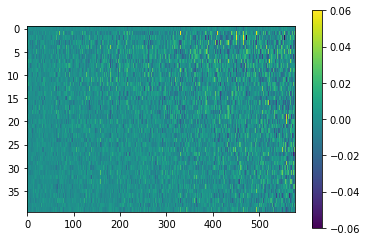

In [209]:
plt.imshow(W_in_list[0], aspect=10, vmin=-0.06, vmax=0.06)
# plt.imshow(W_out_list[0].T, aspect=10, vmin=-0.06, vmax=0.06)
plt.colorbar()

In [ ]:
condition_session_mean_list = []
for (condition, W_in_list, b_in_list) in (mouse_2_conditions, W_cond_in_list, b_cond_in_list):
    session_mean_list = []
    for session in mouse_2_sessions:
        session_data = df[(df['session_id']==session) & (df['condition']==condition)]['traces_raw']
        session_data_projected = W @ session_data + b

In [216]:
np.random.seed(10)
trainp= 0.8
mouse_2_data_dict = {}
for (session, W_in, b_in, W_out, b_out) in zip(mouse_2_sessions, W_in_list, b_in_list, W_out_list, b_out_list):
    session_data = np.array(df[df['session_id']==session]['traces_raw'].tolist())
    session_idxs = np.arange(len(session_data))
    np.random.shuffle(session_idxs)
    trainp_idx = int(0.8 * len(session_data))
    train_session_idxs = session_idxs[:trainp_idx]
    valid_session_idxs = session_idxs[trainp_idx:]
    session = int(session)
    mouse_2_data_dict[session] = {}
    mouse_2_data_dict[session]['train'] = session_data.transpose(0, 2, 1)[train_session_idxs]
    mouse_2_data_dict[session]['valid'] = session_data.transpose(0, 2, 1)[valid_session_idxs]
    mouse_2_data_dict[session]['W_in']  = W_in.transpose(1, 0)
    mouse_2_data_dict[session]['b_in']  = b_in
    mouse_2_data_dict[session]['W_out'] = W_out.transpose(1, 0)
    mouse_2_data_dict[session]['b_out'] = b_out

    
mouse_2_data_dict['dt'] = 6./180

In [218]:
pickle.dump(mouse_2_data_dict, open('./data/mouse_2_brandon.pkl', 'wb'))

In [219]:
mouse_2_data_dict = pickle.load(open('./data/mouse_2_brandon.pkl', 'rb'))

In [73]:
import torch
import torchvision
from torch.utils.data.dataloader import _DataLoaderIter

In [50]:
class LFADS_MultiSession_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data_list, device='cpu'):
        super(LFADS_Multisession_Dataset, self).__init__()
        
        self.data_list   = data_list
        self.device      = device
        self.tensor_list = []
        
        for data in self.data_list:
            self.tensor_list.append(torch.Tensor(data).to(self.device))
            
    def __getitem__(self, ix):
        try:
            return self.tensor_list[ix], ix
        except KeyError:
            raise StopIteration
            
    def __len__(self):
        return len(self.tensor_list)
    
default_collate = torch.utils.data.dataloader._utils.collate.default_collate

class SessionLoader(torch.utils.data.DataLoader):
    
    def __init__(self, dataset, session_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=default_collate, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None):
        
        super(SessionLoader, self).__init__(dataset=dataset,
                                            batch_size=session_size,
                                            shuffle=shuffle,
                                            sampler=sampler,
                                            batch_sampler=batch_sampler,
                                            num_workers=num_workers,
                                            collate_fn=collate_fn,
                                            pin_memory=pin_memory,
                                            drop_last=drop_last,
                                            timeout=timeout,
                                            worker_init_fn=worker_init_fn)
        
    def __iter__(self):
        return _SessionLoaderIter(self)
    
class _SessionLoaderIter(_DataLoaderIter):
    
    def __init__(self, loader):
        super(_SessionLoaderIter, self).__init__(loader)
        
    def __next__(self):
        x, idx = super(_SessionLoaderIter, self).__next__()
        return x.squeeze(), idx

In [55]:
keys = [key for key in mouse_2_data_dict.keys() if type(key) is int]
keys.sort()
train_data_list = [mouse_2_data_dict[key]['train'] for key in keys]
W_in_list = [torch.Tensor(mouse_2_data_dict[key]['W']).to('cuda') for key in keys]
train_ds = LFADS_MultiSession_Dataset(train_data_list, device='cuda')

In [56]:
import importlib
import lfads
importlib.reload(lfads)
from lfads import LFADS_MultiSession_Net

In [57]:
model = LFADS_MultiSession_Net(W_in_list=W_in_list, factor_size=40, device='cuda').to('cuda')

In [58]:
train_dl = SessionLoader(train_ds, sampler=torch.utils.data.RandomSampler(train_ds))

In [59]:
for (x, idx) in train_dl:
    x = x.permute(1, 0, 2)
    recon, factors = model(x, idx)
    loss = (x*recon['rates'].log() - recon['rates'].log()).sum()
    loss.backward()

In [95]:
def SessionSampler(object):
    
    def __init__(dataset):
        self.dataset = dataset
        
    

UsageError: Cell magic `%%source` not found.


In [126]:
train_dl = torch.utils.data.RandomSampler(train_ds)

In [143]:
_DataLoaderIter??

Init signature: _DataLoaderIter(loader)
Source:        
class _DataLoaderIter(object):
    r"""Iterates once over the DataLoader's dataset, as specified by the sampler"""

    # NOTE [ Data Loader Multiprocessing Shutdown Logic ]
    #
    # Preliminary:
    #
    # Our data model looks like this (queues are indicated with curly brackets):
    #
    #                main process                              ||
    #                     |                                    ||
    #               {index_queue}                              ||
    #                     |                                    ||
    #              worker processes                            ||     DATA
    #                     |                                    ||
    #            {worker_result_queue}                         ||     FLOW
    #                     |                                    ||
    #      pin_memory_thread of main process                   ||   DIRECTION
    #                     | 

In [128]:
train_dl._

15